## Rankings clasificación

**Adrián Arnaiz Rodríguez**

Realizaremos rankings de:
1. Experimentos con clasificadores con parámetros por defecto.

2. **TODO** Experimentos con clasificadores con búsqueda de parámetros y preprocesado (SKBest, VT...)
 * Definir pipelines (Pre+Clf)
 * Definir qué parámetros del pipeline serán optimizados.
 * Optimizar y sacar métricas con optimizado



**Clasificadores a utilizar-optimizar**
- Knn
- Tree
- Bayes
- SVM
- RandomF
- Ada
- GBC
- MLP

**Como optimizar clfs y pretratamiento de ccas**
- GS de parametros

In [1]:
import bunch_loader as loader
import pandas as pd
import numpy as np

# 1. Experimentos con sin preprocesado ni búsqueda de parámetros

In [2]:
experiments = False

algoritmos = [
    {
        "ID_ALG":"KNN8",
        "ALGO": "sklearn.neighbors.KNeighborsClassifier",
        "PARAMS":{
            "n_neighbors":8,
            "metric":"euclidean"
        }
    },
    {
        "ID_ALG":"Tree",
        "ALGO": "sklearn.tree.DecisionTreeClassifier",
        "PARAMS":{  # Parámetros por defecto       
        }
    },
    {
        "ID_ALG":"MLP10",
        "ALGO": "sklearn.neural_network.MLPClassifier",
        "PARAMS":{ "hidden_layer_sizes":10,
                  'max_iter':700,
        },
    },
    {
        "ID_ALG":"RF",
        "ALGO": "sklearn.ensemble.RandomForestClassifier",
        "PARAMS":{
        }
    },
    {
        "ID_ALG":"SVM",
        "ALGO": "sklearn.svm.SVC",
        "PARAMS":{
        }
    },
    {
        "ID_ALG":"Bayes",
        "ALGO": "sklearn.naive_bayes.GaussianNB",
        "PARAMS":{  # Parámetros por defecto       
        }
    },
    {
        "ID_ALG":"GBC",
        "ALGO": "sklearn.ensemble.GradientBoostingClassifier",
        "PARAMS":{ 
        }
    },
    {
        "ID_ALG":"Ada",
        "ALGO": "sklearn.ensemble.AdaBoostClassifier",
        "PARAMS":{ 
        }
    },
]

In [3]:
from sklearn.base import clone

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest

from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
import importlib

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')
import time

def run_experiments(modulo, modelos, n_cv=10, verbose=False, checkpoint=None):
    aucs = dict()
    accuracys = dict()
    
    datasets_loaders = [d for d in dir(modulo) if d.startswith('load')]
    
    n_exp_total = len(modelos)*len(datasets_loaders)
    i=1
    
    for dtst in datasets_loaders:
        
        #medimos tiempo de inicio del dataset
        start_dt_time = time.time()
        
        #Inicializamos los datos de este dataset AUC y ACU
        aucs[dtst[5:]]={}
        accuracys[dtst[5:]]={}
        
        #Obtenemos los datos
        data_bunch = getattr(modulo, dtst)()
        X = data_bunch['data']
        y = data_bunch['target']
        
        # Para utilizar los mismos folds en todos los clf, inicializamos los folds: Comparación justa
        skf = StratifiedKFold(n_splits=10)
        cv_generator = list(skf.split(X, y))
        
        if verbose: print('\nDataset: ',dtst)
        
        
        for clf in modelos:
            
            start_clf_time = time.time()
            
            if verbose: print(f'{i}/ {n_exp_total}')
            i+=1
            
            #Cargamos el modelo de manera dinámica
            metodo = clf['ALGO']
            puntos = [pos for pos, char in enumerate(metodo) if char == "."]
            libreria = importlib.import_module(metodo[:puntos[-1]]) #nombre del modulo
            clase = getattr(libreria, metodo[puntos[-1]+1:]) #nombre de la clase
            
            #Creamos y ejecutamos el pipeline de clasificacion
            if 'TUNING' in clf.keys():
                # NESTED CV: 
                # https://scikit-learn.org/stable/tutorial/statistical_inference/
                #       model_selection.html#grid-search-and-cross-validated-estimators
                if verbose: print('TUNING -> '+clf['ID_ALG'], end='[') 
                steps_pipe = [('norm', MinMaxScaler()),
                       ('select', SelectKBest()),
                       ('clf', clase(**clf["PARAMS"]))]
                
                #Renombramos las claves de los parametros del clasificador de param a clf__param y
                # añadimos seleccion de atributos
                pg = {**{'select__k': [10,20,'all']},**dict([('clf__'+p, clf['TUNING'][p]) for p in clf['TUNING']])}
                
                pipe = Pipeline(steps_pipe)
                pip = GridSearchCV(pipe, cv=5, param_grid=pg, scoring = 'roc_auc')
                                   
            else:
                if verbose: print(clf['ID_ALG'], end='[')
                pip = Pipeline([('norm', MinMaxScaler()),
                                ('clf', clase(**clf["PARAMS"]))])
            
            #Ejecutamos cross_validación
            cv_res = cross_validate(pip,
                                    X,y,
                                    cv = cv_generator,
                                    scoring = {'AUC':'roc_auc', 'ACCURACY':'accuracy'}, 
                                    return_train_score=False)
            
            # Guardamos resultados
            aucs[dtst[5:]][clf['ID_ALG']] = cv_res['test_AUC'].mean()
            accuracys[dtst[5:]][clf['ID_ALG']] = cv_res['test_ACCURACY'].mean()
            
            #cv_res
            if verbose:
                print('AUC: {:.3f} +- {:.2f}'.format(cv_res['test_AUC'].mean(), cv_res['test_AUC'].std()), end = ' || ')
                print('ACC: {:.4f} +- {:.2f} ]'.format(cv_res['test_ACCURACY'].mean(), cv_res['test_ACCURACY'].std()))
                print('\t CLFTime: {:.1f} s'.format(time.time()-start_clf_time))
        
        if verbose: 
            clear_output() 
            print(pd.DataFrame(aucs).transpose())
            print('\t DataTime: {:.1f} s'.format(time.time()-start_dt_time))
        
        if checkpoint:
            pd.DataFrame(aucs).transpose().to_csv(checkpoint, header=True, index_label='Dataset')
            print('-------CHECKPOINT-------')
            
    return aucs, accuracys


In [4]:
if experiments:
    auc_res, accuracys_res = run_experiments(loader, algoritmos, 10, verbose=True)
    clf_bin_auc_default = pd.DataFrame(auc_res).transpose()
    clf_bin_auc_default.to_csv('resultados/bin_clf_auc_default.csv', header=True, index_label='Dataset')

In [5]:
clf_bin_auc_default = pd.read_csv('resultados/bin_clf_auc_default.csv')
clf_bin_auc_default

,Dataset,KNN8,Tree,MLP10,RF,SVM,Bayes,GBC,Ada
0,art_rt,0.666000,0.580000,0.692000,0.664000,0.760000,0.694000,0.752000,0.784000
1,art_w_atleta,0.646000,0.570000,0.744000,0.542000,0.684000,0.638000,0.676000,0.732000
2,art_w_braso,0.590000,0.540000,0.572000,0.508000,0.676000,0.692000,0.636000,0.544000
3,art_w_campana,0.638000,0.520000,0.652000,0.638000,0.700000,0.678000,0.668000,0.708000
4,art_w_gato,0.706000,0.550000,0.636000,0.626000,0.676000,0.672000,0.684000,0.632000
5,art_w_petaka,0.594000,0.570000,0.668000,0.674000,0.708000,0.716000,0.724000,0.616000
6,fon_rt,0.522000,0.540000,0.516000,0.616000,0.444000,0.588000,0.692000,0.840000
7,fon_v_A,0.611333,0.590000,0.691556,0.672889,0.685778,0.681778,0.688444,0.652000
8,fon_v_E,0.620444,0.620000,0.736444,0.689111,0.703111,0.715778,0.676000,0.651111
9,fon_v_I,0.640889,0.583333,0.720000,0.651333,0.676889,0.668000,0.685778,0.625333


In [6]:
def best_combinations(df_o, n=10):
    df = df_o.set_index('Dataset')
    best_top_index = np.unravel_index(np.array(-df).argsort(axis=None)[:n],df.shape)
    for i,j in zip(best_top_index[0], best_top_index[1]):
        print(df.index[i],'-',df.columns[j])
        print(df.iloc[i,j])
        print()

In [7]:
best_combinations(clf_bin_auc_default)

fon_rt - Ada
0.8400000000000001

vggish_embed_rt - MLP10
0.8240000000000001

vggish_embed_rt - KNN8
0.8139999999999998

vggish_embed_v_A - GBC
0.8101655328798186

vggish_embed_v_A - MLP10
0.7959297052154194

vggish_embed_rt - SVM
0.792

vggish_embed_v_A - Ada
0.791453514739229

art_rt - Ada
0.784

fon_v_U - MLP10
0.7644444444444444

vggish_embed_v_U - GBC
0.7609960552268245



Maximos por clasificador:

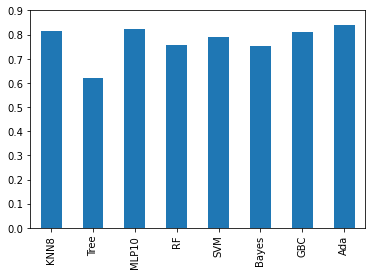

In [8]:
clf_bin_auc_default.drop('Dataset', axis=1).max(axis=0).plot(kind='bar', ylim=[0,0.9])

Medias por clasificador

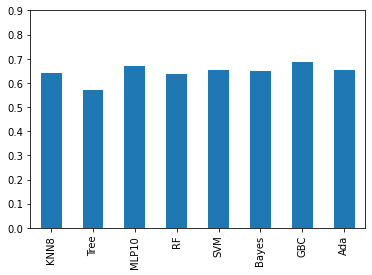

In [9]:
clf_bin_auc_default.drop('Dataset', axis=1).mean(axis=0).plot(kind='bar', ylim=[0,0.9])

Medias y varianza por dataset

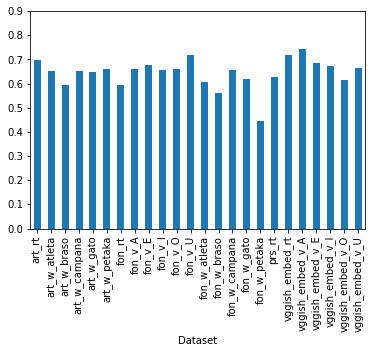

In [10]:
clf_bin_auc_default.set_index('Dataset').mean(axis=1).plot(kind='bar',ylim=[0,0.9])

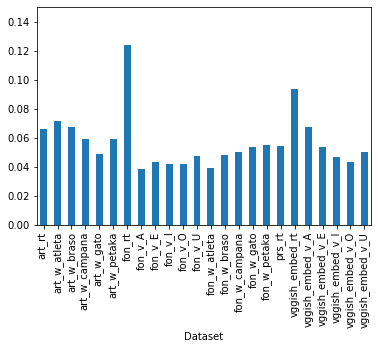

In [11]:
clf_bin_auc_default.set_index('Dataset').std(axis=1).plot(kind='bar',ylim=[0,0.15])

In [12]:
import my_posthoc.post_hoc as ph

In [13]:
df_Hoch, avg_rank, ranks_all, iman_dav = ph.posthoc_Friedman_Davenport_Hochbertest(clf_bin_auc_default) 

### Experimento
# Number of classifiers: 8
# Number of datasets: 24
# Name of classifiers: KNN8, Tree, MLP10, RF, SVM, Bayes, GBC, Ada
# Alpha: 0.05

### Métricas
# Test de Friedman sobre métricas 
	-> p-val: 0.0000

### Rankings
# GBC   ranking medio:  2.667
# MLP10 ranking medio:  3.208
# SVM   ranking medio:  4.104
# Bayes ranking medio:  4.396
# Ada   ranking medio:  4.5
# KNN8  ranking medio:  4.708
# RF    ranking medio:  5.146
# Tree  ranking medio:  7.271
# Test de Ivan-Davenport sobre Rankings [F(10.6997, 7, 161)]               
	-> p-val: 0.0000

### Test Hochberg Comparacion GBC vs all
# Tabla de comparación de Rankings:
                    z        p  alpha/i    sig
GBC vs Tree   6.51104  0.00000  0.00714   True
GBC vs RF     3.50584  0.00046  0.00833   True
GBC vs KNN8   2.88641  0.00390  0.01000   True
GBC vs Ada    2.59225  0.00953  0.01250   True
GBC vs Bayes  2.44518  0.01448  0.01667   True
GBC vs SVM    2.03222  0.04213  0.02500  False
GBC vs MLP10  0.76509  0.44422 

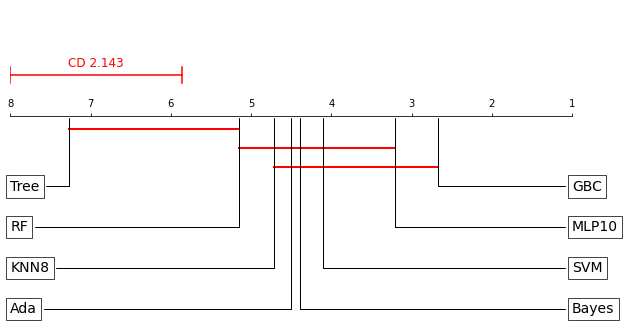

[['Tree', 'RF'],
 ['RF', 'KNN8', 'Ada', 'Bayes', 'SVM', 'MLP10'],
 ['KNN8', 'Ada', 'Bayes', 'SVM', 'MLP10', 'GBC']]

In [14]:
n_dt = clf_bin_auc_default.shape[0]
n_clf = clf_bin_auc_default.shape[1]-1 #Columna de datasets
g = ph.groups_Nemenyi(avg_rank, ph.nemenyi_CD(n_clf, n_dt, alpha=0.05))
ph.plot_nemenyi(avg_rank,ph.nemenyi_CD(n_clf, n_dt, alpha=0.05),g)
g

In [15]:
df_Hoch

,z,p,alpha/i,sig
GBC vs Tree,6.51104,0.00000,0.00714,True
GBC vs RF,3.50584,0.00046,0.00833,True
GBC vs KNN8,2.88641,0.00390,0.01000,True
GBC vs Ada,2.59225,0.00953,0.01250,True
GBC vs Bayes,2.44518,0.01448,0.01667,True
GBC vs SVM,2.03222,0.04213,0.02500,False
GBC vs MLP10,0.76509,0.44422,0.05000,False


### Experimento
# Number of classifiers: 8
# Number of datasets: 24
# Name of classifiers: KNN8, Tree, MLP10, RF, SVM, Bayes, GBC, Ada
# Alpha: 0.05

### Métricas
# Test de Friedman sobre métricas 
	-> p-val: 0.0000

### Rankings
# GBC   ranking medio:  2.667
# MLP10 ranking medio:  3.208
# SVM   ranking medio:  4.104
# Bayes ranking medio:  4.396
# Ada   ranking medio:  4.5
# KNN8  ranking medio:  4.708
# RF    ranking medio:  5.146
# Tree  ranking medio:  7.271
# Test de Ivan-Davenport sobre Rankings [F(10.6997, 7, 161)]               
	-> p-val: 0.0000

### Test Hochberg Comparacion GBC vs all
# Tabla de comparación de Rankings:
                    z        p  alpha/i    sig
GBC vs Tree   6.51104  0.00000  0.00714   True
GBC vs RF     3.50584  0.00046  0.00833   True
GBC vs KNN8   2.88641  0.00390  0.01000   True
GBC vs Ada    2.59225  0.00953  0.01250   True
GBC vs Bayes  2.44518  0.01448  0.01667   True
GBC vs SVM    2.03222  0.04213  0.02500  False
GBC vs MLP10  0.76509  0.44422 

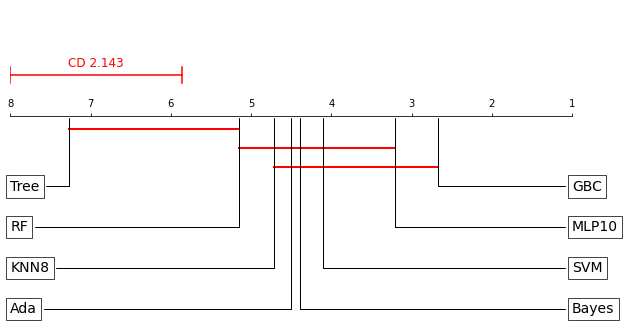

In [16]:
ph.generate_report(clf_bin_auc_default, 
                     output_file='resultados/clf_bin_AUC_DEFAULT.tex', verbose=True)

***Accuracy***

In [17]:
if experiments:
    clf_bin_accuracy_default = pd.DataFrame(accuracys_res).transpose()
    clf_bin_accuracy_default.to_csv('resultados/bin_clf_accuracy_default.csv', header=True, index_label='Dataset')
clf_bin_accuracy_default = pd.read_csv('resultados/bin_clf_accuracy_default.csv')
clf_bin_accuracy_default

,Dataset,KNN8,Tree,MLP10,RF,SVM,Bayes,GBC,Ada
0,art_rt,0.600000,0.580000,0.610000,0.660000,0.620000,0.660000,0.680000,0.700000
1,art_w_atleta,0.630000,0.570000,0.620000,0.490000,0.560000,0.590000,0.590000,0.630000
2,art_w_braso,0.530000,0.540000,0.510000,0.490000,0.610000,0.640000,0.580000,0.530000
3,art_w_campana,0.580000,0.520000,0.600000,0.600000,0.570000,0.640000,0.620000,0.650000
4,art_w_gato,0.670000,0.550000,0.590000,0.560000,0.630000,0.640000,0.600000,0.600000
5,art_w_petaka,0.570000,0.570000,0.660000,0.600000,0.590000,0.650000,0.690000,0.610000
6,fon_rt,0.550000,0.540000,0.540000,0.590000,0.540000,0.590000,0.620000,0.760000
7,fon_v_A,0.583333,0.590000,0.626667,0.650000,0.640000,0.636667,0.656667,0.646667
8,fon_v_E,0.610000,0.620000,0.663333,0.646667,0.646667,0.646667,0.640000,0.616667
9,fon_v_I,0.603333,0.583333,0.666667,0.640000,0.630000,0.630000,0.630000,0.600000


In [18]:
clf_bin_accuracy_default.mean()

KNN8     0.599941
Tree     0.570112
MLP10    0.621646
RF       0.596917
SVM      0.590014
Bayes    0.608521
GBC      0.636870
Ada      0.619600
dtype: float64

In [19]:
clf_bin_accuracy_default.drop('Dataset', axis=1).max()

KNN8     0.700000
Tree     0.620000
MLP10    0.740000
RF       0.683333
SVM      0.680000
Bayes    0.660000
GBC      0.738571
Ada      0.760000
dtype: float64

Post-hoc

In [20]:
df, avg_r, ranks_all, iman_dav = ph.posthoc_Friedman_Davenport_Hochbertest(clf_bin_accuracy_default) 

### Experimento
# Number of classifiers: 8
# Number of datasets: 24
# Name of classifiers: KNN8, Tree, MLP10, RF, SVM, Bayes, GBC, Ada
# Alpha: 0.05

### Métricas
# Test de Friedman sobre métricas 
	-> p-val: 0.0000

### Rankings
# GBC   ranking medio:  2.438
# MLP10 ranking medio:  3.521
# Ada   ranking medio:  4.062
# Bayes ranking medio:  4.396
# RF    ranking medio:  4.771
# KNN8  ranking medio:  5.042
# SVM   ranking medio:  5.333
# Tree  ranking medio:  6.438
# Test de Ivan-Davenport sobre Rankings [F(7.4061, 7, 161)]               
	-> p-val: 0.0000

### Test Hochberg Comparacion GBC vs all
# Tabla de comparación de Rankings:
                    z        p  alpha/i    sig
GBC vs Tree   5.65685  0.00000  0.00714   True
GBC vs SVM    4.09415  0.00004  0.00833   True
GBC vs KNN8   3.68261  0.00023  0.01000   True
GBC vs RF     3.29936  0.00097  0.01250   True
GBC vs Bayes  2.76903  0.00562  0.01667   True
GBC vs Ada    2.29668  0.02164  0.02500   True
GBC vs MLP10  1.53159  0.12562

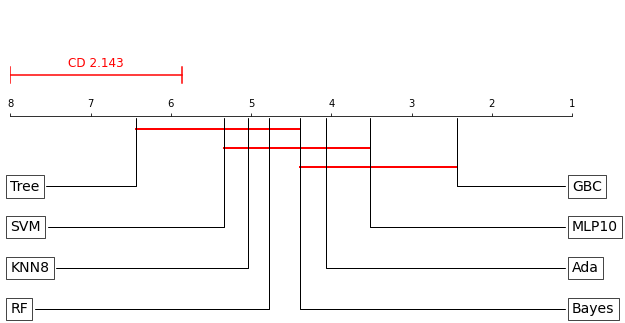

[['Tree', 'SVM', 'KNN8', 'RF', 'Bayes'],
 ['SVM', 'KNN8', 'RF', 'Bayes', 'Ada', 'MLP10'],
 ['Bayes', 'Ada', 'MLP10', 'GBC']]

In [21]:
g = ph.groups_Nemenyi(avg_r, ph.nemenyi_CD(n_clf, n_dt, alpha=0.05))
ph.plot_nemenyi(avg_r,ph.nemenyi_CD(n_clf, n_dt, alpha=0.05),g)
g

# 2. Clasificadores optimizados: TODO

* Grid Search
* Fast Auto ML
* Auto scikitLearn

## Grid Search

In [22]:
experiments_GS = False
algoritmos_tunned = [
    {
        "ID_ALG":"KNN",
        "ALGO": "sklearn.neighbors.KNeighborsClassifier",
        "PARAMS":{
            "n_neighbors":8,
            "metric":'euclidean',
            "weights":"distance"
            
        },
        "TUNING":{
            'n_neighbors':[3,5,9] #overwritte param
        }
    },
    {
        "ID_ALG":"Tree",
        "ALGO": "sklearn.tree.DecisionTreeClassifier",
        "PARAMS":{  # Parámetros por defecto       
        },
        "TUNING":{
            #Solo select k best
        }
    },
    {
        "ID_ALG":"MLP10",
        "ALGO": "sklearn.neural_network.MLPClassifier",
        "PARAMS":{ "hidden_layer_sizes":10,
                  'max_iter':700,
        },
        "TUNING":{
            #Solo k best
        }
    },
    {
        "ID_ALG":"RF",
        "ALGO": "sklearn.ensemble.RandomForestClassifier",
        "PARAMS":{ 'max_depth':4
        },
        "TUNING":{
            'min_samples_leaf':[1,5]
        }
    },
    {
        "ID_ALG":"SVM",
        "ALGO": "sklearn.svm.SVC",
        "PARAMS":{ 'kernel':'rbf'
        },
        "TUNING":{
            'gamma':['auto', 0.01, 1]
        }
    },
    {
        "ID_ALG":"Bayes",
        "ALGO": "sklearn.naive_bayes.GaussianNB",
        "PARAMS":{  # Parámetros por defecto       
        },
        "TUNING":{
            #Solo k best
        }
    },
    {
        "ID_ALG":"GBC",
        "ALGO": "sklearn.ensemble.GradientBoostingClassifier",
        "PARAMS":{ 
        },
        "TUNING":{
            'max_features':['auto','log2']
        }
    },
    {
        "ID_ALG":"Ada",
        "ALGO": "sklearn.ensemble.AdaBoostClassifier",
        "PARAMS":{ 'n_estimators':20
        },
        "TUNING":{
            #Solo k best
        }
    },

]



In [23]:
if experiments_GS:
    auc_res, accuracys_res = run_experiments(loader, algoritmos_tunned,
                                              10, verbose=True, 
                                              checkpoint = 'resultados/bin_clf_auc_tuned.csv')
    clf_bin_auc_tuned = pd.DataFrame(auc_res).transpose()

In [24]:
clf_bin_auc_tuned = pd.read_csv('resultados/bin_clf_auc_tuned.csv')
clf_bin_auc_tuned

,Dataset,KNN,Tree,MLP10,RF,SVM,Bayes,GBC,Ada
0,art_rt,0.732000,0.560000,0.712000,0.792000,0.744000,0.768000,0.732000,0.728000
1,art_w_atleta,0.652000,0.482000,0.680000,0.620000,0.644000,0.704000,0.732000,0.600000
2,art_w_braso,0.534000,0.534000,0.532000,0.580000,0.652000,0.692000,0.644000,0.540000
3,art_w_campana,0.618000,0.500000,0.688000,0.658000,0.680000,0.674000,0.684000,0.702000
4,art_w_gato,0.646000,0.580000,0.592000,0.660000,0.680000,0.670000,0.692000,0.636000
5,art_w_petaka,0.568000,0.550000,0.640000,0.584000,0.692000,0.680000,0.672000,0.688000
6,fon_rt,0.588000,0.520000,0.528000,0.562000,0.612000,0.548000,0.672000,0.718000
7,fon_v_A,0.691111,0.550000,0.738222,0.708000,0.721333,0.708222,0.685778,0.670889
8,fon_v_E,0.660444,0.606667,0.768889,0.734667,0.751111,0.722667,0.644000,0.691111
9,fon_v_I,0.638667,0.590000,0.754667,0.702222,0.723556,0.738889,0.668444,0.659778


In [25]:
best_combinations(clf_bin_auc_tuned)

vggish_embed_rt - KNN
0.8400000000000002

vggish_embed_v_A - GBC
0.8316122448979593

vggish_embed_rt - MLP10
0.8

fon_w_gato - MLP10
0.7958333333333332

vggish_embed_rt - GBC
0.792

art_rt - RF
0.792

vggish_embed_v_A - MLP10
0.7842426303854875

fon_v_U - Bayes
0.7731111111111112

fon_v_E - MLP10
0.7688888888888888

art_rt - Bayes
0.768



### Experimento
# Number of classifiers: 8
# Number of datasets: 24
# Name of classifiers: KNN, Tree, MLP10, RF, SVM, Bayes, GBC, Ada
# Alpha: 0.05

### Métricas
# Test de Friedman sobre métricas 
	-> p-val: 0.0000

### Rankings
# SVM   ranking medio:  3.167
# GBC   ranking medio:  3.312
# MLP10 ranking medio:  3.562
# Bayes ranking medio:  4.333
# RF    ranking medio:  4.458
# KNN   ranking medio:  4.875
# Ada   ranking medio:  5.104
# Tree  ranking medio:  7.188
# Test de Ivan-Davenport sobre Rankings [F(9.0129, 7, 161)]               
	-> p-val: 0.0000

### Test Hochberg Comparacion SVM vs all
# Tabla de comparación de Rankings:
                    z        p  alpha/i    sig
SVM vs Tree   5.68655  0.00000  0.00714   True
SVM vs Ada    2.73933  0.00616  0.00833   True
SVM vs KNN    2.41548  0.01571  0.01000  False
SVM vs RF     1.82575  0.06789  0.01250  False
SVM vs Bayes  1.64897  0.09915  0.01667  False
SVM vs MLP10  0.55861  0.57642  0.02500  False
SVM vs GBC    0.20506  0.83752 

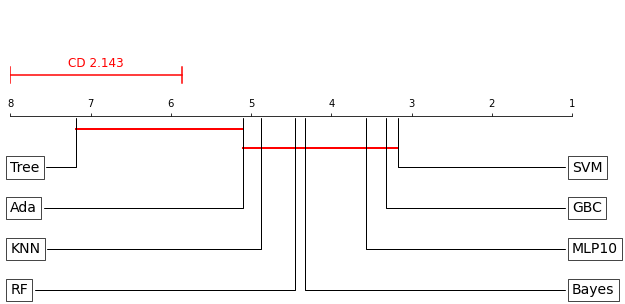

In [26]:
ph.generate_report(clf_bin_auc_tuned, 
                     output_file='resultados/clf_bin_AUC_TUNNED.tex', verbose=True)